In [123]:
# -*- coding: utf-8 -*-
"""
Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

"""
import torch
import torchvision
from torchvision import transforms, datasets

########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose([
    transforms.ToTensor(),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

trainset = datasets.FER2013(root='.', split="train", transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = datasets.FER2013(root='.', split="test", transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

In [127]:
print(testset[100])

(tensor([[[0.6314, 0.6902, 0.7098,  ..., 0.6706, 0.6627, 0.6549],
         [0.6588, 0.7059, 0.7412,  ..., 0.5765, 0.5255, 0.5137],
         [0.7059, 0.7451, 0.6980,  ..., 0.5098, 0.5882, 0.5608],
         ...,
         [0.1098, 0.1294, 0.1333,  ..., 0.5333, 0.1216, 0.1882],
         [0.1255, 0.1255, 0.1059,  ..., 0.4235, 0.1059, 0.1765],
         [0.1608, 0.1529, 0.1137,  ..., 0.3137, 0.0980, 0.1843]]]), None)


angry surprise happy happy


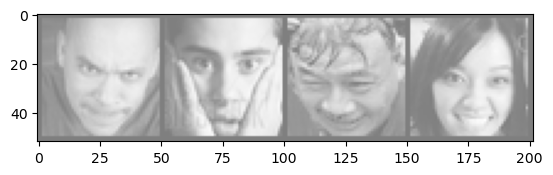

In [128]:
########################################################################
# Let us show some of the training images, for fun.

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [157]:
########################################################################
# 2. Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it waLs defined).

import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*9*9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*9*9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# net.to(device)

In [158]:
########################################################################
# 3. Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


In [ ]:
losses = []
trainAccuracies = []
testAccuracies = []

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    losses.append(running_loss/len(trainloader))
    print('[%d] loss: %.3f' %
              (epoch + 1, running_loss/len(trainloader)))


    # get training accuracy
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    # inputs, labels = inputs.to(device), labels.to(device)
    outputs = net(images)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data

            # images = images.to(device)
            # labels = labels.to(device)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('training accuracy: %d %%' % (
        100 * correct / total))
    trainAccuracies.append(100 * correct / total)

    # # get testing accuracy
    # dataiter = iter(testloader)
    # images, labels = next(dataiter)
    # # images = images.to(device)
    # # labels = labels.to(device)
    # outputs = net(images)

    # correct = 0
    # total = 0
    # with torch.no_grad():
    #     for data in testloader:
    #         images, labels = data

    #         images = images.to(device)
    #         labels = labels.to(device)

    #         outputs = net(images)
    #         _, predicted = torch.max(outputs.data, 1)
    #         total += labels.size(0)
    #         correct += (predicted == labels).sum().item()

    # print('test accuracy: %d %%' % (
    #     100 * correct / total))
    # testAccuracies.append(100 * correct / total)

print('Finished Training')

'''
plotting
'''

# loss graph-------
lossArray = np.array(losses)
plt.plot(lossArray)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss')
plt.show()

# training graph-------
lossArray = np.array(trainAccuracies)
plt.plot(lossArray)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy - Training Data')
plt.show()

# test graph-------
lossArray = np.array(testAccuracies)
plt.plot(lossArray)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy - Test Data')
plt.show()


[1] loss: 1.835
training accuracy: 25 %
[2] loss: 1.749
training accuracy: 35 %
[3] loss: 1.592
training accuracy: 40 %
[4] loss: 1.482
training accuracy: 46 %
[5] loss: 1.389
training accuracy: 49 %
[6] loss: 1.312
training accuracy: 53 %
[7] loss: 1.237
training accuracy: 58 %
[8] loss: 1.158
training accuracy: 60 %
[9] loss: 1.080
training accuracy: 65 %
[10] loss: 0.998
training accuracy: 70 %
[11] loss: 0.911
training accuracy: 70 %
[12] loss: 0.830
training accuracy: 72 %


In [ ]:
########################################################################
# 5. Test the network on the test data
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
#
# We have trained the network for 2 passes over the training dataset.
# But we need to check if the network has learnt anything at all.
#
# We will check this by predicting the class label that the neural network
# outputs, and checking it against the ground-truth. If the prediction is
# correct, we add the sample to the list of correct predictions.
#
# Okay, first step. Let us display an image from the test set to get familiar.

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

########################################################################
# Okay, now let us see what the neural network thinks these examples above are:

outputs = net(images)

########################################################################
# The outputs are energies for the 10 classes.
# Higher the energy for a class, the more the network
# thinks that the image is of the particular class.
# So, let's get the index of the highest energy:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

########################################################################
# The results seem pretty good.
#
# Let us look at how the network performs on the whole dataset.

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

########################################################################
# That looks waaay better than chance, which is 10% accuracy (randomly picking
# a class out of 10 classes).
# Seems like the network learnt something.
#
# Hmmm, what are the classes that performed well, and the classes that did
# not perform well:

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


In [ ]:
########################################################################
#
# Training on GPU
# ----------------
# Just like how you transfer a Tensor on to the GPU, you transfer the neural
# net onto the GPU.
#
# Let's first define our device as the first visible cuda device if we have
# CUDA available:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

########################################################################
# The rest of this section assumes that `device` is a CUDA device.
#
# Then these methods will recursively go over all modules and convert their
# parameters and buffers to CUDA tensors:
#
# .. code:: python
#
#     net.to(device)
#
#
# Remember that you will have to send the inputs and targets at every step
# to the GPU too:
#
# .. code:: python
#
#         inputs, labels = inputs.to(device), labels.to(device)
#
# Why dont I notice MASSIVE speedup compared to CPU? Because your network
# is realllly small.
#
# **Exercise:** Try increasing the width of your network (argument 2 of
# the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` –
# they need to be the same number), see what kind of speedup you get.
#
# **Goals achieved**:
#
# - Understanding PyTorch's Tensor library and neural networks at a high level.
# - Train a small neural network to classify images
#
# Training on multiple GPUs
# -------------------------
# If you want to see even more MASSIVE speedup using all of your GPUs,
# please check out :doc:`data_parallel_tutorial`.
#
# Where do I go next?
# -------------------
#
# -  :doc:`Train neural nets to play video games </intermediate/reinforcement_q_learning>`
# -  `Train a state-of-the-art ResNet network on imagenet`_
# -  `Train a face generator using Generative Adversarial Networks`_
# -  `Train a word-level language model using Recurrent LSTM networks`_
# -  `More examples`_
# -  `More tutorials`_
# -  `Discuss PyTorch on the Forums`_
# -  `Chat with other users on Slack`_
#
# .. _Train a state-of-the-art ResNet network on imagenet: https://github.com/pytorch/examples/tree/master/imagenet
# .. _Train a face generator using Generative Adversarial Networks: https://github.com/pytorch/examples/tree/master/dcgan
# .. _Train a word-level language model using Recurrent LSTM networks: https://github.com/pytorch/examples/tree/master/word_language_model
# .. _More examples: https://github.com/pytorch/examples
# .. _More tutorials: https://github.com/pytorch/tutorials
# .. _Discuss PyTorch on the Forums: https://discuss.pytorch.org/
# .. _Chat with other users on Slack: http://pytorch.slack.com/messages/beginner/